In [25]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lazypredict.Supervised import LazyClassifier, LazyRegressor
import pickle
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings 
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('toxicity_parsed_dataset.csv')
df.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.90,0.10,0
1,1,` :Clarification for you (and Zundark's righ...,1.00,0.00,0
2,2,Elected or Electoral? JHK,1.00,0.00,0
3,3,`This is such a fun entry. Devotchka I once...,1.00,0.00,0
4,4,Please relate the ozone hole to increases in c...,0.80,0.20,0


In [27]:
# Before renaming the columns
print("\nBefore modifying column names:\n", df.columns)

df.rename(columns = {'index':'id','oh_label':'label','Text':'tweet'}, inplace = True)
  
# After renaming the columns
print("\nAfter modifying first column:\n", df.columns)


Before modifying column names:
 Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label'], dtype='object')

After modifying first column:
 Index(['id', 'tweet', 'ed_label_0', 'ed_label_1', 'label'], dtype='object')


In [28]:
train2, test2 = train_test_split(df, test_size=0.3,random_state=10, shuffle=True)

train2 = train2[['id','label','tweet']]
test2 = test2[['id','tweet']]

print("Training Set 2 :"% train2.columns, train2.shape)
print("Test Set 2 :"% test2.columns, test2.shape)
print('Train Set 2 -----')
print(train2.isnull().sum())
print('Test Set 2 -----')
print(test2.isnull().sum())
train2.head()

Training Set 2 : (111780, 3)
Test Set 2 : (47906, 2)
Train Set 2 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 2 -----
id       0
tweet    0
dtype: int64


,id,label,tweet
69140,69140,0,", 30 July 2008 (UTC) *: *double-checks your us..."
157499,157499,0,born 31march 1995 Yes
83922,83922,0,dated prod|concern = confirmed sockpuppet] of ...
30953,30953,0,Where is that documented? It's certainly not...
150734,150734,0,`:Perfectly fine - we'll appreciate your contr...


In [29]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test2, "tweet")
train_clean = clean_text(train2, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    101040
0    101040
Name: label, dtype: int64

In [30]:
train_upsampled

,id,label,tweet
119445,119445,1,itnc go fuck yourself
91259,91259,1,alright well do us all a favor fuck off no o...
105550,105550,1,see you next tuesday c u n t c u n t c u ...
93174,93174,1,i think you went overboard here and blew your...
145971,145971,1,asshole censor keeps censoring paid mole ...
...,...,...,...
141273,141273,0,section 1b of the gacr states it complies wi...
9372,9372,0,say tim could you take a look at the e...
93553,93553,0,ahcene bendjazia well dont get me started the...
94735,94735,0,no i dont think you mean to be obnoxious i th...


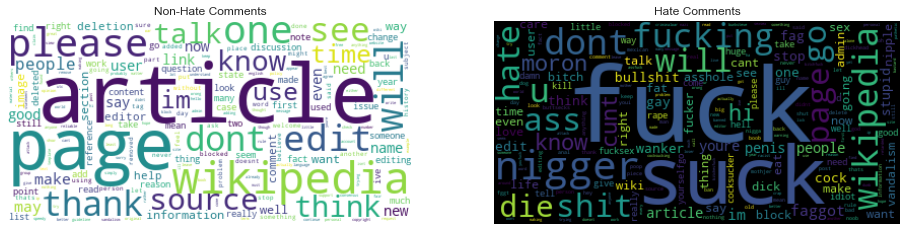

In [31]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train2.label == 0])
text_neg = " ".join(train_clean['tweet'][train2.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

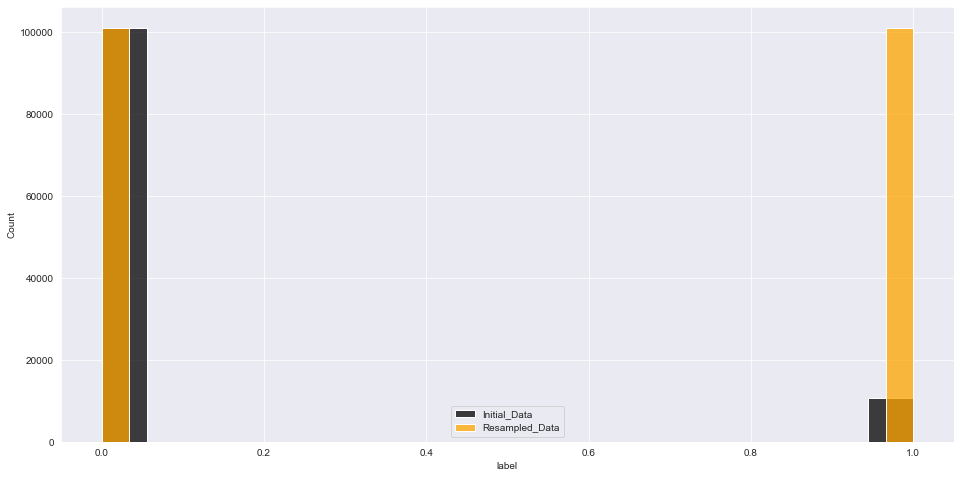

In [32]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train2['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


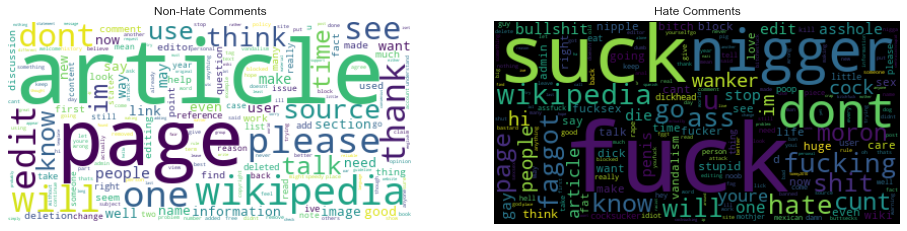

In [33]:
print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train2.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train2.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [34]:
dt_trasformed = train_upsampled[['label', 'tweet']]
y = dt_trasformed.iloc[:, :-1].values

In [35]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))

In [36]:
y_df = pd.DataFrame(y)
y_hate = np.array(y_df[0])

In [37]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(train_upsampled['tweet']).toarray()

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y_hate, test_size = 0.30, random_state = 1)


[[30185   121]
 [ 2013 28305]]


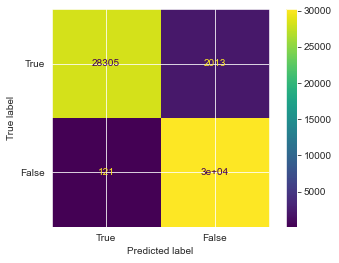

y_hat_shape for Decision Tree:  (60624, 2)
----------------------------------------
Decision Tree Accuracy:  0.964799419371866
F1 score:  0.9636728857415225
----------------------------------------


In [39]:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Start timer
start_time = time.time()

classifier_dt.fit(x_train, y_train)

# End timer
end_time = time.time()

#confusion matrix
#Decision Tree
y_pred_dt = classifier_dt.predict(x_test)
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred_dt, labels = [1,0]), display_labels = [True, False])
cm_display.plot()
plt.show()

yhat_dt = classifier_dt.predict_proba(x_test)
print('y_hat_shape for Decision Tree: ',yhat_dt.shape)
yhat_dt = yhat_dt[:, 1]
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test, yhat_dt)
auc_dt = round(metrics.roc_auc_score(y_test, yhat_dt), 4)
dt_score = accuracy_score(y_test, y_pred_dt)
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)